# Introdução ao Firedrake  

&nbsp;

## Parte 4: Problemas Transientes

&nbsp;

Ministrante: **Diego Tavares Volpatto (LNCC/ESSS)**
&nbsp;

Encontro Acadêmico de Modelagem Computacional - XV EAMC (2022)

<tr>
<td> <img src="../img/logo_eamc.png" alt="Drawing" style="width: 200px;"/> </td>
<td> <img src="../img/banner.png" alt="Drawing" style="width: 550px;"/> </td>
</tr>

## Sumário

Conceitos-chaves:

* Solução de um problema transiente
* Reaproveitamento de solver
* Euler implícito

# Equação do Calor

## Um problema transiente

Vamos considerar a "Eq. do Calor" como a extensão imediata da Eq. de Poisson para o caso transiente.

### Poisson

\begin{equation}
\begin{cases}
  \nabla \cdot (-K \nabla p) = f & \text{em } \Omega \\[0.5em]
  p = p_D & \text{sobre } \Gamma_D \\[0.5em]
  (-K \nabla p)\cdot \mathbf{n} = g & \text{sobre } \Gamma_N
\end{cases}       
\end{equation}

### Equação do Calor

\begin{equation}
\begin{cases}
  \dfrac{\partial p}{\partial t} + \nabla \cdot (-K \nabla p) = f & \text{em } \Omega \\[0.5em]
  p = p_D & \text{sobre } \Gamma_D \\[0.5em]
  (-K \nabla p)\cdot \mathbf{n} = g & \text{sobre } \Gamma_N \\[0.5em]
  p(x, t = 0) = p_0 & \forall x \in \Omega 
\end{cases}       
\end{equation}

Note agora a presença de uma Condição Inicial!

## Formulação Variacional

Há a inclusão do termo temporal, então se obtém a forma semi-discreta:

\begin{equation}
\int_\Omega \dfrac{\partial p}{\partial t} q \,dx + \int_\Omega K \nabla p \nabla q \,dx = \int_\Omega f\,q \,dx + \int_{\Gamma_N} g\, q \,ds
\end{equation}

A discretização da derivada temporal pode ser com qualquer método que tenha esse propósito. Por simplicidade, aqui vamos considerar o método de Euler Implícito:

\begin{equation}
\int_\Omega \dfrac{p^{n+1} - p^{n}}{d t} q \,dx + \int_\Omega K \nabla p^{n+1} \nabla q \,dx = \int_\Omega f\,q \,dx + \int_{\Gamma_N} g\, q \,ds
\end{equation}

## Formulação Variacional

Na forma abstrata, temos então:

\begin{equation}
a(p^{n+1}, q) = L(q)
\end{equation}

Sendo

\begin{equation}
a(p^{n+1}, q) := \dfrac{1}{d t}(p^{n+1}, q)_\Omega + (K \nabla p^{n+1}, \nabla q)_\Omega
\end{equation}

\begin{equation}
L(q) := \dfrac{1}{d t}(p^{n}, q)_\Omega + (f, q)_\Omega + \langle g, q \rangle_{\Gamma_N}
\end{equation}

Neste caso, o método de integração temporal é simples e a extensão da formulação foi direta. 

Para cada passo de tempo, temos que solucionar um "problema de Poisson" para $p^{n+1}$.

# Implementação

## Considerações

Para fins didáticos, vamos considerar o seguinte:

* $K = 1$
* Como nas outras aulas anteriores, vamos considerar um termo de fonte suave
* $dt = 0.001$
* O problema não está modelando nenhum caso físico em específico (é um toy problem apenas)

## Pré-definições e imports

Vamos carregar tudo que iremos precisar:

In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from firedrake import *

## Definição da malha

Intervalo unitário com 20 elementos:

In [3]:
num_elements = 20
mesh = UnitIntervalMesh(num_elements)

## Declaração dos Espaços e Funções

Os espaços de funções se mantêm sem mudanças:

In [4]:
degree = 1
V = FunctionSpace(mesh, "CG", degree)

Precisaremos das funções sendo ligeiramente diferentes em relação aos problemas estacionários, já que vamos ter que atualizar seus valores ao longo das iterações no tempo:

In [5]:
p = Function(V)
p_n = Function(V)
q = TestFunction(V)

A função `p` representará a solução que queremos no passo de tempo (ou seja, $p^{n+1}$). Já `p_n` é a solução no passo de tempo anterior. A função teste continua como habitual, mas note que não teremos mais a "Trial Function".

## Condições iniciais

Aqui temos uma novidade. Precisamos definir as condições iniciais por se tratar de um problema transiente.

In [6]:
x, = SpatialCoordinate(mesh)
ic = Constant(0)  # por simplicidade

E então deixar já atribuído à solução no passo $n = 0$:

In [7]:
p_n.assign(ic)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7f5ecef3fee0>, FiniteElement('Lagrange', interval, 1), name=None), Mesh(VectorElement(FiniteElement('Lagrange', interval, 1), dim=1), 1)), 4)

## Condições de Contorno essenciais e termo-fonte

Vamos adotar valores compatíveis entre Condições Iniciais e de Contorno com termo-fonte.

Termo fonte:

Condição de Contorno:

In [8]:
expr = sin(2 * pi * x)
f = Function(V).interpolate(div(-grad(expr)))

In [9]:
boundary_value = 0.0
bcs = DirichletBC(V, boundary_value, [1, 2])

## Formulação Variacional

## Forma fraca

\begin{equation}
a(p^{n+1}, q) = L(q)
\end{equation}

Sendo

\begin{equation}
a(p^{n+1}, q) := \dfrac{1}{d t}(p^{n+1}, q)_\Omega + (K \nabla p^{n+1}, \nabla q)_\Omega
\end{equation}

\begin{equation}
L(q) := \dfrac{1}{d t}(p^{n}, q)_\Omega + (f, q)_\Omega + \langle g, q \rangle_{\Gamma_N}
\end{equation}

### Implementação

In [10]:
dt = 0.001  # passo de tempo
K = Constant(1)

a = inner((p - p_n) / dt, q) * dx
a += inner(K * grad(p), grad(q)) * dx
L = f * q * dx
F = a - L

A implementação agora usa o resíduo da formulação! Vamos entender o motivo disso...

## Problema Variacional

Para resolver problemas transientes, precisamos atualizar valores de funções nas formulações implementadas para sermos eficientes (evitar overheads).

No Firedrake, isso é possível por meio da utilizaçao do `NonlinearVariationalProblem`, apesar do problema, em teoria, ser linear.

In [11]:
problem = NonlinearVariationalProblem(F, p, bcs=bcs)

Essa função recebe o resíduo (é mais genérico), em vez do clássico $a = L$, que é reservado para problemas lineares. O problema se torna não-linear (do ponto de vista computacional) porque precisamos atualizar `p_n` em cada passo de tempo e $p$ não é uma "Trial Function".

## Inicialização do Solver

O solver também usa seu equivalente "não-linear", mas a interface se mantém basicamente a mesma:

In [12]:
solver_parameters = {
    'mat_type': 'aij',
    'snes_tyoe': 'newtonls',
    'pc_type': 'lu'
}
solver = NonlinearVariationalSolver(problem, solver_parameters=solver_parameters)

A diferença é que precisamos agora definir um método "não-linear" (na PETSc, são chamados de `snes`) e que também não vamos executar o solver uma única vez, vamos solucionar em cada passo de tempo! Mas podemos reaproveitá-lo sempre!

## Critério de convergência (opcional)

Para detectar se o Estado Estacionário foi alcançado (e diminuir o tempo de execução aqui), vamos tirar a norma $l^2$ entre a solução atual e a anterior. Se o valor for menor que um certo threshold, vamos encerrar a evolução temporal:

In [13]:
norm_l2 = 1.0  # Qualquer valor maior que a tolerância
tolerance = 1.e-3

## Solucionando ao longo do tempo

Finalmente, o loop de solução ao longo do tempo:

In [14]:
t = dt
total_time = 1.0
step = 0
solutions = []
solutions.append(Function(p_n)) # cria uma cópia de p_n (CUIDADO AQUI!)
while t < total_time and norm_l2 > tolerance:
    step += 1
    print('============================')
    print(f'\ttime = {t:.3e}')
    print(f'\tstep = {step}')

    solver.solve()
    norm_l2 = norm(p - p_n, mesh=mesh)
    print(f'\tnorm = {norm_l2:.3e}')
    p_n.assign(p)

    t += dt

    solutions.append(Function(p))
    print('============================')

	time = 1.000e-03
	step = 1
	norm = 2.663e-02
	time = 2.000e-03
	step = 2
	norm = 2.561e-02
	time = 3.000e-03
	step = 3
	norm = 2.463e-02
	time = 4.000e-03
	step = 4
	norm = 2.368e-02
	time = 5.000e-03
	step = 5
	norm = 2.278e-02
	time = 6.000e-03
	step = 6
	norm = 2.191e-02
	time = 7.000e-03
	step = 7
	norm = 2.107e-02
	time = 8.000e-03
	step = 8
	norm = 2.026e-02
	time = 9.000e-03
	step = 9
	norm = 1.949e-02
	time = 1.000e-02
	step = 10
	norm = 1.874e-02
	time = 1.100e-02
	step = 11
	norm = 1.802e-02
	time = 1.200e-02
	step = 12
	norm = 1.733e-02
	time = 1.300e-02
	step = 13
	norm = 1.667e-02
	time = 1.400e-02
	step = 14
	norm = 1.603e-02
	time = 1.500e-02
	step = 15
	norm = 1.542e-02
	time = 1.600e-02
	step = 16
	norm = 1.483e-02
	time = 1.700e-02
	step = 17
	norm = 1.426e-02
	time = 1.800e-02
	step = 18
	norm = 1.371e-02
	time = 1.900e-02
	step = 19
	norm = 1.319e-02
	time = 2.000e-02
	step = 20
	norm = 1.268e-02
	time = 2.100e-02
	step = 21
	norm = 1.220e-02
	time = 2.200e-02
	ste

## Visualizando (bônus)

Como bônus, vamos fazer uma animação dos resultados no notebook!

<IPython.core.display.Javascript object>


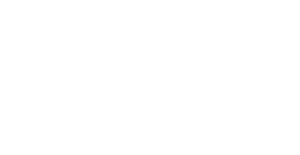

In [15]:
x_values = mesh.coordinates.vector().dat.data

fig, ax = plt.subplots(figsize=(6, 4))
line, = ax.plot([], [])
ax.set_ylim(-1, 1)
ax.set_xlim((x_values.min(), x_values.max()))
ax.set_xlabel("x")
ax.set_ylabel("p(x, t)")

def animate(id_frame):
    u_h = solutions[id_frame]
    u_array = u_h.vector().dat.data
    line.set_data(x_values, u_array)
    return line

anim = FuncAnimation(fig, animate, frames=len(solutions), interval=20)
plt.close()

E então... (powered by Java Script)

In [16]:
from IPython.display import HTML
HTML(anim.to_jshtml())